<a href="https://colab.research.google.com/github/wahyunirosyidah/Machine-Learning-Path/blob/main/LokaJamu_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (
    RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation,
    Dense, Flatten, Dropout
)
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm as colormap
from ipywidgets import widgets
from IPython.display import display
from io import BytesIO


In [17]:
!pip install tensorflowjs

In [18]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/Project Capstone/Machine Learning-LokaJamu'
# %cd '/content/drive/MyDrive/Machine Learning-LokaJamu'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Project Capstone/Machine Learning-LokaJamu


In [19]:
# Directory Path
BASE_DIR = 'Dataset'
print(f"Base Directory: {os.listdir(BASE_DIR)}")

data_train=f'{BASE_DIR}/train'
print(f"Train Directory: {sorted(os.listdir(data_train))}")
data_validation=f'{BASE_DIR}/valid'
print(f"Valid Directory: {sorted(os.listdir(data_validation))}")
data_test=f'{BASE_DIR}/test'
print(f"Test Directory: {sorted(os.listdir(data_test))}")


Base Directory: ['valid', 'train', 'test']
Train Directory: ['Asam Jawa', 'Belimbing Sayur', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Serai']
Valid Directory: ['Asam Jawa', 'Belimbing Sayur', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Serai']
Test Directory: ['Asam Jawa', 'Belimbing Sayur', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Serai']


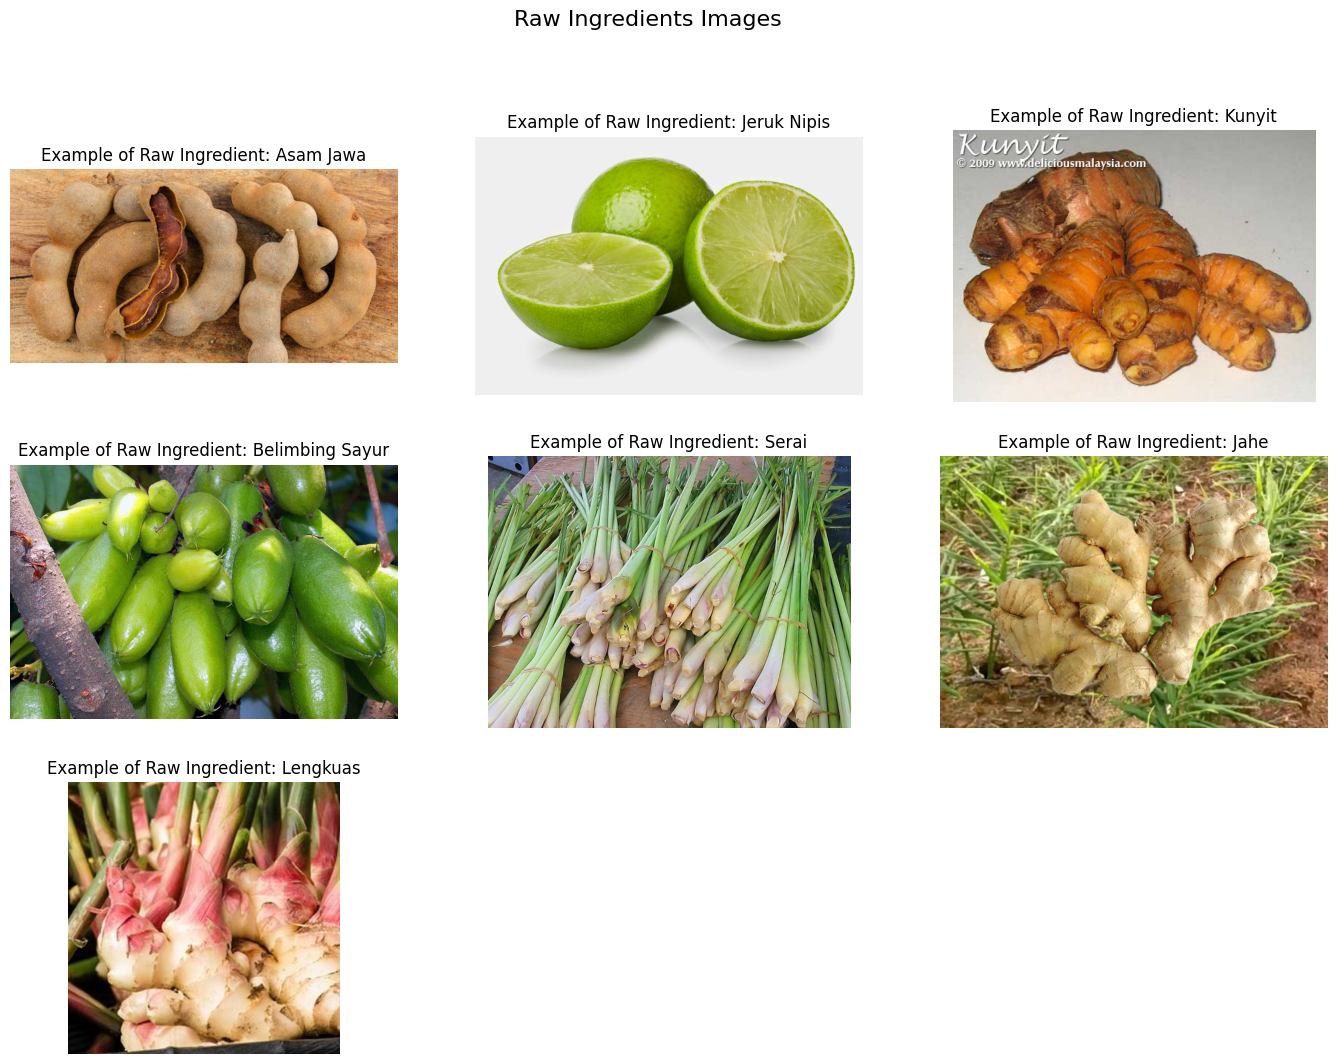

In [20]:
# Plot Raw Ingredient Images
fig, axes = plt.subplots(3, 3, figsize=(17, 12))
fig.suptitle('Raw Ingredients Images', fontsize=16)

# List of Ingredients
ingredients_list = os.listdir(data_train)
# Plot images for each ingredient
for ii, ingredient in enumerate(ingredients_list):
    dir_path = f'{data_train}/{ingredient}'
    img = tf.keras.preprocessing.image.load_img(dir_path + '/' + os.listdir(dir_path)[0])
    row, col = divmod(ii, 3)
    axes[row, col].imshow(img)
    axes[row, col].set_title(f'Example of Raw Ingredient: {ingredient}')
    axes[row, col].axis('off')

# Disable axis on empty subplots if any
for jj in range(len(ingredients_list), 9):
    row, col = divmod(jj, 3)
    axes[row, col].axis('off')

plt.show()

In [21]:
# Display Image Size
sample_array = tf.keras.preprocessing.image.img_to_array(img)
print(f"Each image has size: {sample_array.shape}")


Each image has size: (500, 500, 3)


In [22]:
sample_array[0,:5]

array([[72., 74., 24.],
       [72., 74., 24.],
       [72., 74., 25.],
       [72., 74., 25.],
       [70., 73., 28.]], dtype=float32)

In [23]:
BATCH_SIZE=32

In [24]:
train_datagen = ImageDataGenerator(
                    rescale=1/255,
                                     rotation_range=10,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     fill_mode='reflect')

valid_datagen = ImageDataGenerator(
                    rescale=1./255)

test_datagen = ImageDataGenerator(
                    rescale=1./255)

In [25]:
train_generator = train_datagen.flow_from_directory(
        data_train,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(
        data_validation,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        data_test,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        shuffle=False)

Found 1813 images belonging to 7 classes.
Found 385 images belonging to 7 classes.
Found 392 images belonging to 7 classes.


In [26]:
based_model = MobileNetV2(input_shape=(224,224,3), include_top=False)

for layer in based_model.layers:
  layer.trainable = False


In [27]:
def model_to_use():
    model = tf.keras.models.Sequential([
        based_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(7, activation='softmax')
    ])

    return model

In [28]:
model = model_to_use()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       8,028,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,287,687 (39.24 MB)

 Trainable params: 8,029,447 (30.63 MB)

 Non-trainable params: 2,258,240 (8.61 MB)

In [29]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [30]:
epoch = 15
history = model.fit(train_generator,
                    batch_size=BATCH_SIZE,
                    epochs=epoch,
                    validation_data=validation_generator,
                    shuffle=True)

Epoch 1/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 76s 840ms/step - accuracy: 0.6920 - loss: 0.9100 - val_accuracy: 0.9273 - val_loss: 0.2499
Epoch 2/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 63s 722ms/step - accuracy: 0.8967 - loss: 0.3036 - val_accuracy: 0.9455 - val_loss: 0.1745
Epoch 3/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 47s 726ms/step - accuracy: 0.9252 - loss: 0.2317 - val_accuracy: 0.9558 - val_loss: 0.1491
Epoch 4/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 46s 719ms/step - accuracy: 0.9344 - loss: 0.1846 - val_accuracy: 0.9351 - val_loss: 0.1560
Epoch 5/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 47s 739ms/step - accuracy: 0.9466 - loss: 0.1634 - val_accuracy: 0.9584 - val_loss: 0.1366
Epoch 6/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 736ms/step - accuracy: 0.9541 - loss: 0.1287 - val_accuracy: 0.9688 - val_loss: 0.1169
Epoch 7/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 725ms/step - accuracy: 0.9510 - loss: 0.1573 - val_accuracy: 0.9584 - val_loss: 0.1347
Epoch 8/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 83s 745ms/step - accuracy: 0.9475 - loss: 0.1375 - val_accu

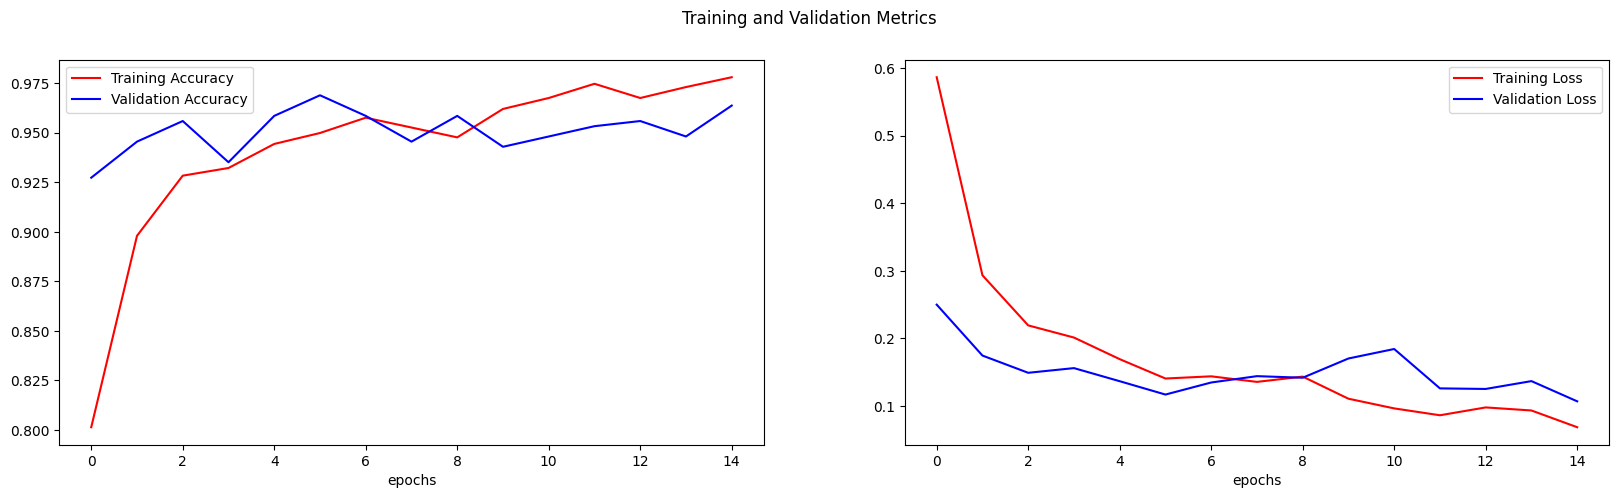

In [31]:
# Plot training and validation accuracy & loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Training and Validation Metrics')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [32]:
num_test_files = sum([len(files) for r, d, files in os.walk(data_test)])
num_test_steps = num_test_files // 32


acc = model.evaluate(test_generator, batch_size=BATCH_SIZE, verbose=1, steps=num_test_steps)[1] * 100
print(f"Accuracy on the test set is {acc:.2f} %")

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 513ms/step - accuracy: 0.9267 - loss: 0.1982
Accuracy on the test set is 94.01 %


13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 741ms/step


<ipython-input-33-d7b6c1a5ddbf>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = colormap.get_cmap('tab10', len(filtered_labels)).colors


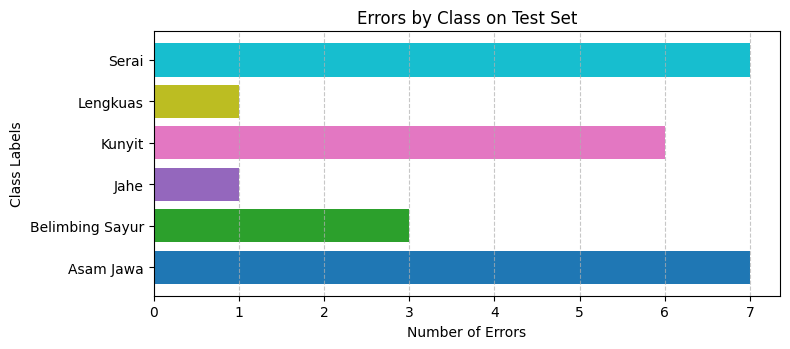

In [33]:
predictions = model.predict(test_generator, verbose=1)

y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)
errors_per_class = conf_matrix.sum(axis=1) - np.diag(conf_matrix)

class_labels = list(test_generator.class_indices.keys())

filtered_labels = [label for label, errors in zip(class_labels, errors_per_class) if errors > 0]
filtered_errors = [errors for errors in errors_per_class if errors > 0]

colors = colormap.get_cmap('tab10', len(filtered_labels)).colors

plt.figure(figsize=(8, len(filtered_labels) * 0.6))
plt.barh(filtered_labels, filtered_errors, color=colors)
plt.title('Errors by Class on Test Set', fontsize=12)
plt.xlabel('Number of Errors', fontsize=10)
plt.ylabel('Class Labels', fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


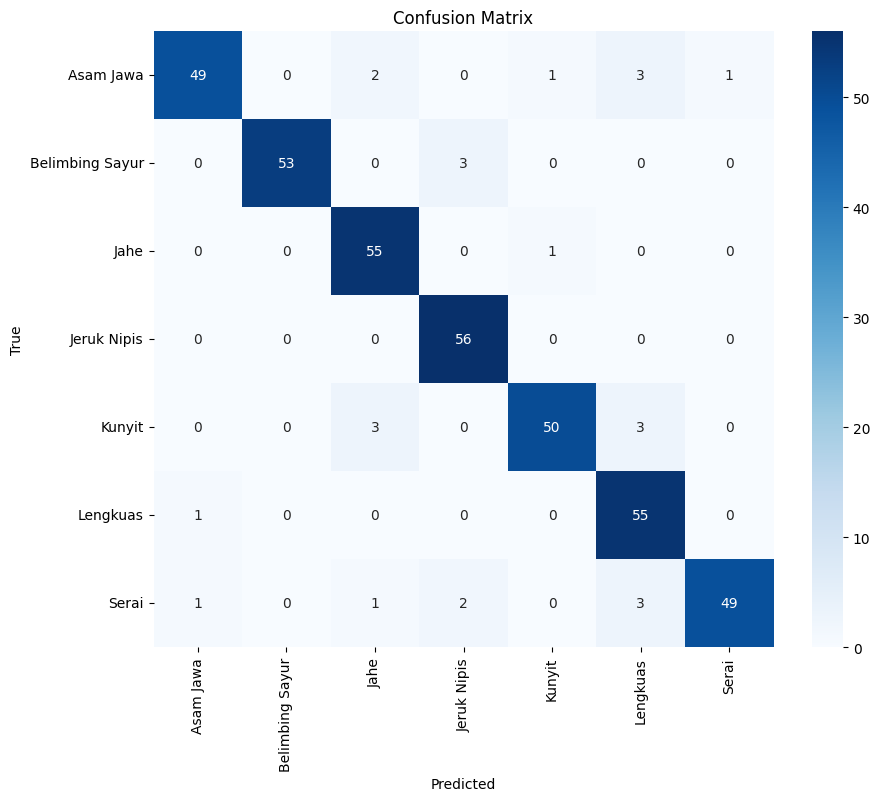

In [34]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



In [35]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:
                 precision    recall  f1-score   support

      Asam Jawa       0.96      0.88      0.92        56
Belimbing Sayur       1.00      0.95      0.97        56
           Jahe       0.90      0.98      0.94        56
    Jeruk Nipis       0.92      1.00      0.96        56
         Kunyit       0.96      0.89      0.93        56
       Lengkuas       0.86      0.98      0.92        56
          Serai       0.98      0.88      0.92        56

       accuracy                           0.94       392
      macro avg       0.94      0.94      0.94       392
   weighted avg       0.94      0.94      0.94       392



In [39]:
def process_image(image_path, target_size=(224, 224)):

    image = load_img(image_path, target_size=target_size)
    image_array = img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

def predict_image(model, file_content, class_labels):

    image = load_img(BytesIO(file_content), target_size=(224, 224))
    processed_image = img_to_array(image) / 255.0
    processed_image = np.expand_dims(processed_image, axis=0)

    prediction = model.predict(processed_image)[0]
    predicted_class = np.argmax(prediction)

    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {class_labels[predicted_class]} (Confidence: {prediction[predicted_class]*100:.2f}%)")
    plt.show()

    print("Prediction Probabilities:")
    for i, prob in enumerate(prediction):
        print(f"{class_labels[i]}: {prob*100:.2f}%")

uploader = widgets.FileUpload(accept="image/*", multiple=False)
display(uploader)

output = widgets.Output()
display(output)

def on_file_upload(change):
    with output:
        output.clear_output()
        for filename, file_info in uploader.value.items():
            file_content = file_info["content"]
            print(f"Processing file: {filename}")
            #Predict Image
            predict_image(model_to_use, file_content, class_labels)

class_labels = list(test_generator.class_indices.keys())

model_to_use = model

uploader.observe(on_file_upload, names="value")


FileUpload(value={}, accept='image/*', description='Upload')

Output()

In [37]:
saved_model_path = "model_to_use"
tf.saved_model.save(model, saved_model_path)

In [38]:
!tensorflowjs_converter --input_format=tf_saved_model {saved_model_path} ./model_to_use/

2024-12-12 00:15:05.300914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733962505.322253   19124 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733962505.328558   19124 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2024-12-12 00:15:09.408822: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1733962509.409030   19124 gpu_device.cc:2022] Created device /job:localhost/replica:0/task